In [1]:
from os import path
if not ( path.exists('c2db.db') or path.exists('typeIII.pickle') ):
  !curl --remote-name -H 'Accept: application/vnd.github.v3.raw' --location 'https://api.github.com/repos/mayhd3/DIPC/contents/typeIII.pickle'


In [2]:
import sys
try:
    import ase.db
except ImportError:
    !{sys.executable} -m pip install ase asr gpaw
    import ase.db
import pickle
from itertools import product

print("Collecting type III heterojunctions...")

# Check that a is in ascending order
def ascending(a): return all(
    a[i]<a[i+1] for i in range(len(a)-1)
)

def candidate(left, right):
    # Apply attr to each combination of band energies with given suffix
    def calculation(attr, suffix): return (
        attr(row,band)
            for row in (left,right)
            for band in ('vbm'+suffix,'cbm'+suffix)
    )

    # Find the x-y*n closest to 0
    def fit(l, r):
        y = min(abs(l),abs(r))
        if y==0:
            return 0
        x = max(abs(l),abs(r))
        return ((x + y/2)%y) - y/2

    def fit_lat(l, r):
        (l_lat, r_lat) = (
            row.data['results-asr.structureinfo.json']['kwargs']['data']['spglib_dataset']['std_lattice']
                for row in (l, r)
        )
        return sum(( abs(fit(l_lat[y][x], r_lat[y][x])) for x, y in product((0,1,2), repeat=2) ))

    # Only compare bands calculated with the same functional, prefer GW > HSE > PBE
    for (functional,suffix) in (('GW','_gw'),('HSE','_hse'),('PBE','')):
        if all(calculation(hasattr,suffix)):
            lvbm,lcbm,rvbm,rcbm = calculation(getattr,suffix)
            # Center bands on evac=0
            lvbm,lcbm,rvbm,rcbm = (
                lvbm - left.evac,
                lcbm - left.evac,
                rvbm - right.evac,
                rcbm - right.evac
            )
            if all((
                # Only accept thermodynamically stable materials
                left.thermodynamic_stability_level == 3 and right.thermodynamic_stability_level == 3, 
                left.is_magnetic == 0 and right.is_magnetic == 0, # Do not accept magnetic materials
                functional == 'HSE', # Only accept HSE functionals
                getattr(left,'class',None) == getattr(right,'class',None), # Materials must have the same phase
                left.spgnum == right.spgnum, # Materials must have the same space group
                left.crystal_type == right.crystal_type, # Materials must have the same crystal structure
                not 'C' in left.crystal_type, # Only accept A or AB type crystal structures 
                ascending((lvbm,lcbm,rvbm,rcbm)) # Gap is broken and bands are rising 
            )):
                return (
                    left.formula,                   #0
                    left.uid,                       #1
                    lvbm,                           #2
                    lcbm,                           #3
                    right.formula,                  #4
                    right.uid,                      #5
                    rvbm,                           #6
                    rcbm,                           #7
                    functional,                     #8
                    getattr(left,'class',None),     #9
                    left.spacegroup,                #10
                    left.crystal_type,              #11
                    rcbm - lvbm,                    #12
                    left.cell_area/right.cell_area, #13
                    fit_lat(left, right)             #14
                )

headers = [     # The title of each candidate column
    'Left',     #0
    'uid',      #1
    'vbm',      #2
    'cbm',      #3
    'Right',    #4
    'uid',      #5
    'vbm',      #6
    'cbm',      #7
    'Calc',     #8
    'Class',    #9
    'Group',    #10
    'Type',     #11
    'ΔE',       #12
    'R',        #13
    'ΔL'        #14
]

try:
    with open('typeIII.pickle','rb') as pk:
        typeIII = pickle.load(pk)
        print("Loaded from pickle.")
except (OSError, IOError):
    # Connect to the database
    db = ase.db.connect('c2db.db')
    # Find rows that have all of the parameters used to choose candidates
    rows = list(db.select('evac,thermodynamic_stability_level,is_magnetic,spgnum,crystal_type,has_asr_structureinfo'))
    # Find pairs of rows that could be type III heterojunctions
    typeIII = sorted(
        list( filter(
            lambda row: row != None, # Remove results that were not candidates
            [candidate(l,r) for l in rows for r in rows] # Take every pair in the selection
        ) ),
        key = lambda t: t[14] # Sort by how well the lattices fit
    )
    print("Loaded from ase db.")
    with open('typeIII.pickle','wb') as pk: # Cache results to make plot changes load faster
        pickle.dump(typeIII, pk)
        print("Dumped to pickle.")

Loaded from pickle.


In [3]:
import pandas as pd
from tabulate import tabulate

spgs = pd.unique([t[10] for t in typeIII]) # Find which space groups we found pairs from
print("Collected " + str(len(typeIII)) + " type III heterojunctions from " + str(len(spgs)) + " space groups:")

best = [next(t for t in typeIII if t[10] == s) for s in spgs] # The best pair from each spacegroup
print(tabulate(best, headers)) # Print out a table of the best pairs

Collected 427 type III heterojunctions from 13 space groups:
Left    uid                       vbm       cbm  Right    uid                       vbm       cbm  Calc    Class    Group    Type              ΔE         R          ΔL
------  -------------------  --------  --------  -------  -------------------  --------  --------  ------  -------  -------  ----------  --------  --------  ----------
Hg2Se2  Hg2Se2-f2919d1605f0  -6.09644  -5.80772  In2I2    I2In2-9ab97b2e26fc   -5.72337  -4.38874  HSE              P-1      AB-2-i      1.70771   0.999259  0.00363588
Mo2S4   Mo2S4-b06001f565b8   -5.92049  -5.851    Cr2Se4   Cr2Se4-27ef6952ebef  -4.93085  -4.88631  HSE     TMDC-T'  P2_1/m   AB2-11-e    1.03418   1.0151    0.0977598
TiSe2   TiSe2-509ef368050d   -6.28639  -4.82595  CrTe2    CrTe2-c31911a1b3f9   -4.65162  -3.78291  HSE     TMDC-H   P-6m2    AB2-187-bi  2.50347   1.01453   0.232332
GeSe2   GeSe2-a6ec24f37a20   -6.01069  -5.63241  TiSe2    TiSe2-320be81440f3   -4.74139  -4.59395  HSE

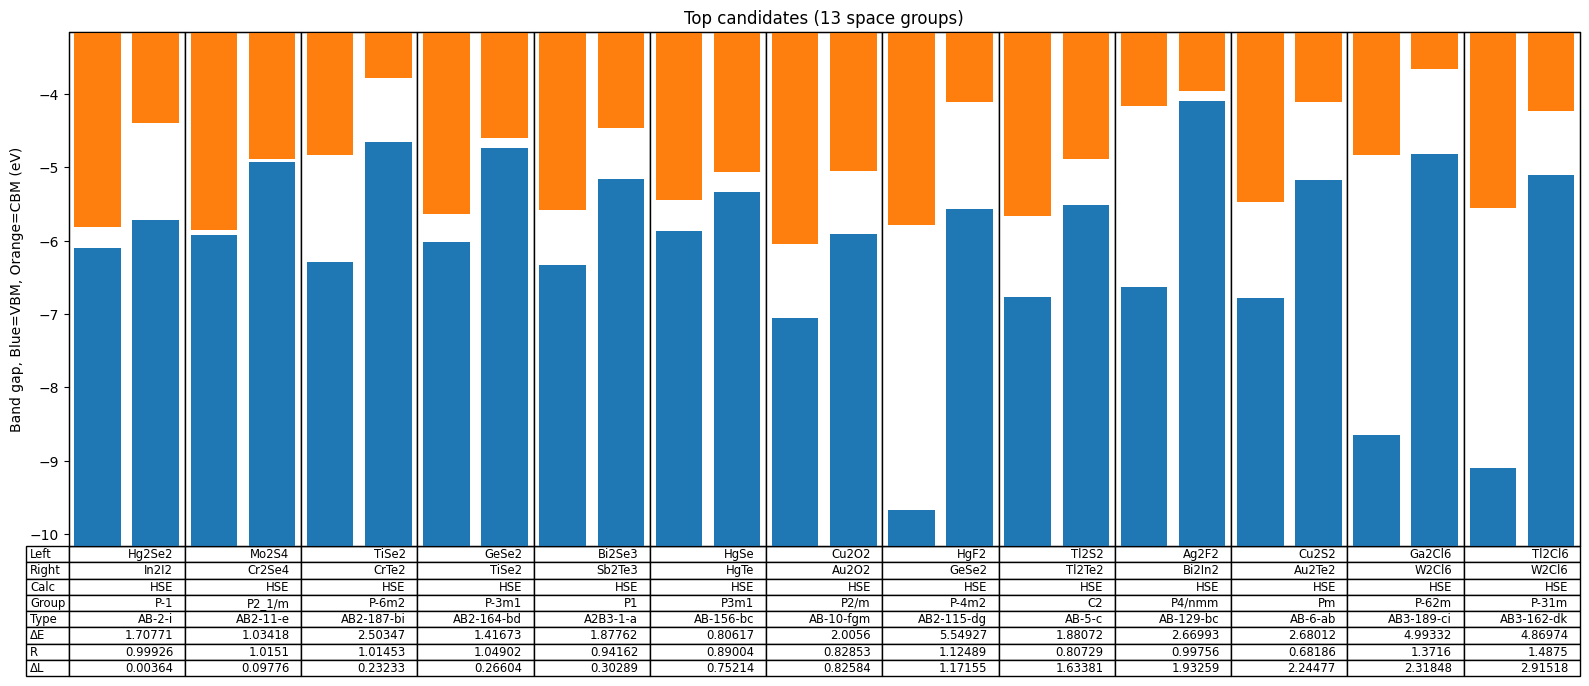

In [4]:

import numpy as np
import matplotlib.pyplot as plt

table_headers_indices = [0,4,8,10,11,12,13,14] # Which headers to display in the table

def bands_with_table(pairs): # Plot each pair of candidates, with bars for the band gaps, and a table for other stats
    ax = plt.subplot(label=str(id(pairs)))
    ax.margins(x=0)

    flatx = range(len(pairs)*2)

    if(flatx == range(0)):
        return

    leftvbm = np.array([t[2] for t in pairs])
    leftcbm = np.array([t[3] for t in pairs])
    emin = np.amin(leftvbm) - .5

    rightvbm = np.array([t[6] for t in pairs])
    rightcbm = np.array([t[7] for t in pairs])
    emax = np.amax(rightcbm) + .5

    leftx = flatx[::2]
    ax.bar(leftx, leftvbm-emin, bottom=emin, color='C0')
    ax.bar(leftx, leftcbm-emax, bottom=emax, color='C1')
    #ax.bar(leftx, leftvbm-leftcbm, bottom=leftcbm)

    rightx = flatx[1::2]
    ax.bar(rightx, rightvbm-emin, bottom=emin)
    ax.bar(rightx, rightcbm-emax, bottom=emax)
    #ax.bar(rightx, rightvbm-rightcbm, bottom=rightcbm)

    ax.set_xlim(-.5,len(flatx)-.5)
    ax.set_ylim(emin,emax)

    plt.xticks([],[])

    table = plt.table(
        cellText = [
            [ t[i] if not isinstance(t[i], float) else round(t[i],5) for t in pairs ]
                for i in table_headers_indices
        ],
        rowLabels=[headers[i] for i in table_headers_indices],
        loc='bottom'
    )
    table.auto_set_font_size(False)
    table.set_fontsize('small')

    plt.table(
        cellText = [['' for x in leftx]],
        bbox=[0,0,1,1]
    )

    plt.ylabel('Band gap, Blue=VBM, Orange=CBM (eV)')

plt.figure(figsize=(16,7),dpi=100)
bands_with_table(best)
plt.title("Top candidates (" + str(len(spgs)) + " space groups)")
plt.tight_layout()

plt.show()

In [5]:
from IPython.display import display
import ipywidgets as widgets

ddown = widgets.Dropdown(
    options=spgs,
    description='Space group:',
    style={'description_width': 'initial'}
)

spacegroup = None
def selected(row):
    global spacegroup
    spacegroup = [t for t in typeIII if t[10] == ddown.value] # Rows in this group
ddown.observe(selected, names='value')
selected(None)

slide = widgets.IntRangeSlider(
    value=(0,20),
    description='Candidate indices:',
    style={'description_width': 'initial'},
    disabled=False
)

def selected_max(row):
    slide.max = len(spacegroup)
    upper = min(slide.value[1],slide.max)
    lower = min(slide.value[0],upper)
    slide.value = (lower,upper)
ddown.observe(selected_max, names='value')
selected_max(None)

bands = widgets.Button(description='VBM, CBM')
ratio = widgets.Button(description='ΔE, R')

output = widgets.Output()

def pressed(button):
    with output:
        output.clear_output(wait=True)
        top = spacegroup[slide.value[0]:slide.value[1]] # Top 20 rows in this space group
        plt.figure(figsize=(16,7),dpi=100)
        if button==bands:
            bands_with_table(top)
        if button==ratio:
            plt.scatter(
                x=[s[12] for s in top],
                y=[s[13] for s in top]
            )
            for s in top: # Label scatter plot points with formulas
                plt.annotate(s[0]+","+s[4],(s[12],s[13]))
            plt.xlabel(headers[12] + " (eV)")
            plt.ylabel(headers[13] + " (1)")

        plt.title(ddown.value + " (top " + str(slide.value[0]) + "-" + str(slide.value[1]) + " of " + str(len(spacegroup)) + " candidates)")
        plt.tight_layout()
        plt.show()

        for row in range(len(top)):
            tup = list(top[row])
            tup[1] = '<a target="_blank" href="' + 'https://cmrdb.fysik.dtu.dk/c2db/row/' + tup[1] + '">' + tup[1] + '</a>'
            tup[5] = '<a target="_blank" href="' + 'https://cmrdb.fysik.dtu.dk/c2db/row/' + tup[5] + '">' + tup[5] + '</a>'
            top[row] = tup

        display(widgets.HTML(
            "<style>tr:hover { background-color: gainsboro !important; } tr { background-color: white !important; }</style>" +
            tabulate(top, headers, floatfmt=".3f", tablefmt="unsafehtml")
        ))

bands.on_click(pressed)
ratio.on_click(pressed)

display(ddown, slide, bands, ratio, output)

Dropdown(description='Space group:', options=('P-1', 'P2_1/m', 'P-6m2', 'P-3m1', 'P1', 'P3m1', 'P2/m', 'P-4m2'…

IntRangeSlider(value=(0, 20), description='Candidate indices:', max=49, style=SliderStyle(description_width='i…

Button(description='VBM, CBM', style=ButtonStyle())

Button(description='ΔE, R', style=ButtonStyle())

Output()